In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint

pp = pprint.PrettyPrinter(indent = 4)

file_path = "C:\\Users\\chris\\Downloads\\adult.csv"
raw_data = pd.read_csv(file_path)

In [2]:
pp.pprint(dict(zip(raw_data.columns, raw_data.dtypes)))

{   'age': dtype('int64'),
    'capital-gain': dtype('int64'),
    'capital-loss': dtype('int64'),
    'education': dtype('O'),
    'educational-num': dtype('int64'),
    'fnlwgt': dtype('int64'),
    'gender': dtype('O'),
    'hours-per-week': dtype('int64'),
    'income': dtype('O'),
    'marital-status': dtype('O'),
    'native-country': dtype('O'),
    'occupation': dtype('O'),
    'race': dtype('O'),
    'relationship': dtype('O'),
    'workclass': dtype('O')}


In [3]:
df = raw_data.replace(to_replace = "?", value = np.nan)

### Data cleaning: impute missing categorical vars using distribution of values conditional on income

In [4]:
def prImpute(var, df):
    cts = df.groupby("income")[var].value_counts()
    rich_cts = {}
    poor_cts = {}
    for i in zip(cts.index, cts.values):
        if i[0][0] == "<=50K":
            poor_cts[i[0][1]] = i[1]
        else:
            rich_cts[i[0][1]] = i[1]
    r_sum = sum(rich_cts.values())
    p_sum = sum(poor_cts.values())
    rich_prs = {i:rich_cts[i]/r_sum for i in rich_cts.keys()}
    poor_prs = {i:poor_cts[i]/p_sum for i in poor_cts.keys()}
    
    
    r_n = len(df[df.income == ">50K"])
    p_n = len(df) - r_n
    
        
    df.loc[(df[var].isnull()) & (df["income"] == ">50K"), var] = np.random.choice(a = list(rich_prs.keys()), size = r_n - r_sum, p = list(rich_prs.values()))
    df.loc[(df[var].isnull()) & (df["income"] == "<=50K"), var] = np.random.choice(a = list(poor_prs.keys()), size = p_n - p_sum, p = list(poor_prs.values()))

    return df



In [5]:
missing_cols = df.isna().any()
d = dict(zip(missing_cols.index, missing_cols.values))
for i in d:
    if d[i]:
        df = prImpute(i, df)

In [6]:
df.isna().any()

age                False
workclass          False
fnlwgt             False
education          False
educational-num    False
marital-status     False
occupation         False
relationship       False
race               False
gender             False
capital-gain       False
capital-loss       False
hours-per-week     False
native-country     False
income             False
dtype: bool

### Data cleaning: drop unnecessary columns

In [7]:
drop_cols = ["fnlwgt", "educational-num", "marital-status", "capital-gain", "capital-loss"]

In [8]:
df = df.drop(columns = drop_cols)

In [9]:
df

,age,workclass,education,occupation,relationship,race,gender,hours-per-week,native-country,income
0,25,Private,11th,Machine-op-inspct,Own-child,Black,Male,40,United-States,<=50K
1,38,Private,HS-grad,Farming-fishing,Husband,White,Male,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,Protective-serv,Husband,White,Male,40,United-States,>50K
3,44,Private,Some-college,Machine-op-inspct,Husband,Black,Male,40,United-States,>50K
4,18,Self-emp-not-inc,Some-college,Adm-clerical,Own-child,White,Female,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,Assoc-acdm,Tech-support,Wife,White,Female,38,United-States,<=50K
48838,40,Private,HS-grad,Machine-op-inspct,Husband,White,Male,40,United-States,>50K
48839,58,Private,HS-grad,Adm-clerical,Unmarried,White,Female,40,United-States,<=50K
48840,22,Private,HS-grad,Adm-clerical,Own-child,White,Male,20,United-States,<=50K


### Data cleaning: workclass

In [10]:
df.workclass.value_counts()

Private             36011
Self-emp-not-inc     4083
Local-gov            3317
State-gov            2115
Self-emp-inc         1772
Federal-gov          1510
Without-pay            24
Never-worked           10
Name: workclass, dtype: int64

In [11]:
df = df[~ df.workclass.isin(["Without-pay", "Never-worked"])]

In [12]:
df.workclass.value_counts()

Private             36011
Self-emp-not-inc     4083
Local-gov            3317
State-gov            2115
Self-emp-inc         1772
Federal-gov          1510
Name: workclass, dtype: int64

In [13]:
df.loc[df.workclass.isin(["Self-emp-not-inc", "Self-emp-inc"]), "workclass"] = "Self-emp"

C:\Users\chris\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [14]:
df.workclass.value_counts()

Private        36011
Self-emp        5855
Local-gov       3317
State-gov       2115
Federal-gov     1510
Name: workclass, dtype: int64

### Data cleaning: education

In [15]:
df.education.value_counts()

HS-grad         15768
Some-college    10871
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1809
Assoc-acdm       1599
10th             1386
7th-8th           952
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: education, dtype: int64

In [16]:
df.loc[df.education.str.contains(r'(.*\d.*)|(Preschool)'), "education"] = "<HS"
df.loc[df.education.str.contains(r'.*Assoc.*'), "education"] = "Assoc"

C:\Users\chris\Anaconda3\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [17]:
df.education.value_counts()

HS-grad         15768
Some-college    10871
Bachelors        8025
<HS              6399
Assoc            3660
Masters          2657
Prof-school       834
Doctorate         594
Name: education, dtype: int64

### Data cleaning: native-country

In [18]:
df.loc[df["native-country"] == 'United-States', "native-country"] = "US"
df.loc[df["native-country"] != 'US', "native-country"] = "Not US"


In [19]:
df["native-country"].value_counts()

US        44585
Not US     4223
Name: native-country, dtype: int64

In [153]:
df.head()

,age,workclass,education,occupation,relationship,race,gender,hours-per-week,native-country,income
0,25,Private,<HS,Machine-op-inspct,Own-child,Black,Male,40,US,<=50K
1,38,Private,HS-grad,Farming-fishing,Husband,White,Male,50,US,<=50K
2,28,Local-gov,Assoc,Protective-serv,Husband,White,Male,40,US,>50K
3,44,Private,Some-college,Machine-op-inspct,Husband,Black,Male,40,US,>50K
4,18,Self-emp,Some-college,Adm-clerical,Own-child,White,Female,30,US,<=50K


### Data cleaning: encode categorical vars

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

In [21]:
X = df.loc[:, df.columns != 'income']
y = df.income

In [22]:
obj_cols = [col for col in X.columns if X[col].dtypes == "object"]

In [23]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [24]:
oh_df = pd.DataFrame(encoder.fit_transform(X[obj_cols]))
oh_df.index = X.index

In [25]:
X = pd.concat([X.drop(columns = obj_cols), oh_df], axis = 1)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

### Functions for model evaluation

In [27]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.base import clone

In [93]:
def getBestModel(model, hyperparam_dict, X_train = X_train, y_train = y_train, cv = 3,  grid_search = False, iters = 20):
    """
    Given model and hyperparameters, returns best model (already fitted) and corresponding parameters
    
    Inputs:     model:               empty model
                hyperparam_dict:     dict of lists {hyperparameter 1: [value 1, .... ,value n]}
                cv:                  number of folds for k-fold cross validation
                grid_search:         if True, consider all possible combinations of hyperparameters; 
                                     if False, consider only a random sample of all possible combinations
                iters:               only applies when grid_search is False; size of random sample
    
    Ouputs:     best_model:          fitted model with best hyperparameters
                best_params:         best hyperparameters determined from cross-validation
    """
    if grid_search:
        search = GridSearchCV(estimator = model, param_grid = hyperparam_dict, \
                              cv = cv, verbose=3, n_jobs = -1)    
    else:
        search = RandomizedSearchCV(estimator = model, param_distributions = hyperparam_dict, \
                              n_iter = iters, cv = cv, verbose=3, n_jobs = -1)
    
    search.fit(X_train, y_train)
    best_params = search.best_params_
    
    best_model = clone(model).set_params(**best_params).fit(X_train, y_train)
        
    return best_model, best_params


In [30]:
def plotCM(fitted_model, X_test = X_test, y_test = y_test):
    """
    plots confusion matrix for given model
    """
    disp = plot_confusion_matrix(fitted_model, X_test, y_test,
                                 display_labels=labels,
                                 cmap=plt.cm.Blues,
                                 normalize="true")
    disp.ax_.set_title("Normalized confusion matrix")

    print("Normalized confusion matrix")
    print(disp.confusion_matrix)

### Baseline accuracy

In [28]:
labels = ['<=50K', '>50K']
print(y_test.value_counts()/len(y_test))

<=50K    0.762416
>50K     0.237584
Name: income, dtype: float64


* How well a model does is relative
* In classification, should compare model accuracy to proportion of majority class in dataset (if we had a naive model that just predicted the majority class every single time, it would be correct {# of points in majority class/total # of points}% of the time)
* So, our models should be at least this good

*In our case, our models should be able to achieve at least 76% accuracy (note: accuracy = # of points classified correctly/total # of points tested)*

### Classification: Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression

#### Fitting LR model with unbalanced classes

In [32]:
u_lr_model = LogisticRegression(max_iter = 1000).fit(X_train, y_train)

In [33]:
u_lr_model.score(X_test, y_test) #accuracy of model; % of points correctly classified

0.831257170955581

Is this good? What other information are we missing?

#### Check true positive, true negative, false positive, false negative rates

In [35]:
u_lr_yhat = u_lr_model.predict(X_test) #predictions for points in X_test

In [36]:
tp = 0      #true positive (predict +, actually +)
fp = 0      #false positive (predict -, actually +)
tn = 0      #true negative (predict -, actually -)
fn = 0      #false negative (predict +, actually -)
p = 0       #total # of actual +
n = 0       #total # of actual -
for i in zip(y_test, u_lr_yhat):
    if i[0] == ">50K": #actual positive
        p += 1
        if i[1] == ">50K":
            tp +=1
        else:
            fn += 1
    else: #actual negative
        n += 1
        if i[1] == "<=50K":
            tn += 1
        else:
            fp += 1
#convert to probabilities
print(np.array([tn,fp])/n) #[Pr(predict - | actually -), Pr(predict + | actually -)]
print(np.array([fn,tp])/p) #[Pr(predict - | actually +), Pr(predict + | actually +)]


[0.91776846 0.08223154]
[0.44636081 0.55363919]


Normalized confusion matrix
[[0.91776846 0.08223154]
 [0.44636081 0.55363919]]


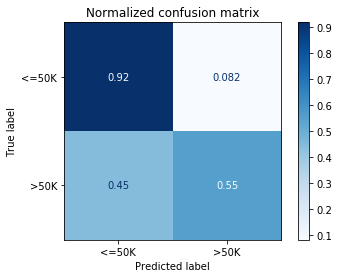

In [34]:
plotCM(u_lr_model)

Let >50K be "positive" and <=50K be negative.
* Pros: very high true negative rate, very low false positive rate
* Cons: very high false negative rate, very low true positive rate

*Why do we get these results?* 

#### Fitting LR model with balanced classes

In [37]:
lr_model = LogisticRegression(max_iter = 1000, class_weight = "balanced").fit(X_train, y_train)

In [38]:
lr_model.score(X_test, y_test)

0.7898705130306507

In [148]:
cross_val_score(lr_model, X_train, y_train)

array([0.79541109, 0.78664117, 0.78841688, 0.79087556, 0.78636798])

Normalized confusion matrix
[[0.77362141 0.22637859]
 [0.15798551 0.84201449]]


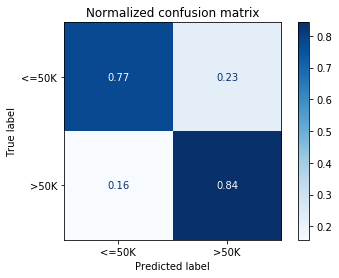

In [39]:
plotCM(lr_model)

* Lower accuracy score than before, but much lower Type I and Type II errors

### Classification: SVM

In [47]:
from sklearn.svm import SVC

#### Unbalanced:

Note: fitting model takes forever since data has so many dimensions, best if we do dimensionality reduction before fitting

In [48]:
usvm_model = SVC().fit(X_train,y_train)
usvm_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [49]:
usvm_model.score(X_test, y_test)

0.8100311424356663

Normalized confusion matrix
[[0.95904547 0.04095453]
 [0.66816143 0.33183857]]


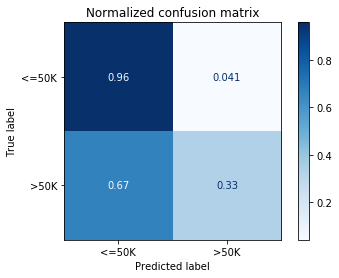

In [50]:
plotCM(usvm_model)

* High accuracy and true negative rate, but very very low true positive rate

In [144]:
usvm_yhat = usvm_model.predict(X_test)

In [146]:
pd.Series(usvm_yhat).value_counts()/len(usvm_yhat)

<=50K    0.889936
>50K     0.110064
dtype: float64

#### Balanced:

In [51]:
svm_model = svm.SVC(class_weight = "balanced").fit(X_train,y_train)
svm_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [52]:
svm_model.score(X_test, y_test)

0.7597934764792657

Normalized confusion matrix
[[0.73094701 0.26905299]
 [0.14763712 0.85236288]]


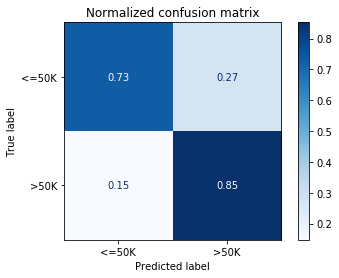

In [53]:
plotCM(svm_model, X_test, y_test)

* A whole lot better than the unbalanced SVM in terms of true positive/true negative, but poor overall accuracy

### Classification: Decision Tree

In [54]:
from sklearn.tree import DecisionTreeClassifier

#### Unbalanced:

In [124]:
udt_model = DecisionTreeClassifier().fit(X_train, y_train)
udt_model.score(X_test, y_test)

0.7806097361088347

Normalized confusion matrix
[[0.86455982 0.13544018]
 [0.48878924 0.51121076]]


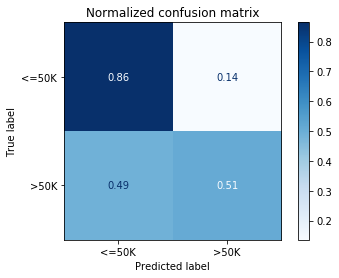

In [125]:
plotCM(udt_model)

#### Balanced:

In [60]:
dt_model = DecisionTreeClassifier(class_weight = "balanced").fit(X_train, y_train)

In [62]:
dt_model.score(X_test, y_test)

0.7715948205212261

In [63]:
cross_val_score(dt_model, X_train, y_train, cv=5, scoring = "accuracy") 
# Accuracy scores for each iteration of 5-fold cross-validation 

array([0.77192024, 0.77544051, 0.77612348, 0.77462095, 0.77175249])

Normalized confusion matrix
[[0.82263786 0.17736214]
 [0.39220421 0.60779579]]


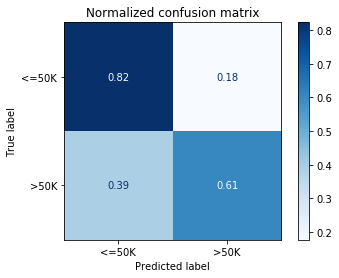

In [64]:
plotCM(dt_model)

* Even with balanced class-weight, still not great

#### Hyperparameter optimization (exhaustive grid search):

In [67]:
#Get a sense of what current parameters are

print(f"Depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")

Depth: 42
Number of leaves: 7784


In [119]:
#Grid of parameters to check
dt_grid = {
 'max_depth': [10, 20, 30, 40, 50, None],
 'max_leaf_nodes': [5000, 6000, 7000, 8000, 9000, 10000, None]
}

In [120]:
best_dt, best_dt_hyperparams = getBestModel(DecisionTreeClassifier(class_weight = "balanced"),dt_grid, grid_search = True)

#Since grid_search is True, will look at all possible combinations of hyperparameters (ex: (10,5000), (10, 6000)...)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:   23.9s finished


In [121]:
pp.pprint(best_dt_hyperparams)

{'max_depth': 20, 'max_leaf_nodes': 6000}


In [122]:
best_dt.score(X_test, y_test)

0.7783150303228978

In [149]:
cross_val_score(best_dt, X_train, y_train)

array([0.78516799, 0.78336293, 0.77803579, 0.78199699, 0.77666985])

Normalized confusion matrix
[[0.79243255 0.20756745]
 [0.26698862 0.73301138]]


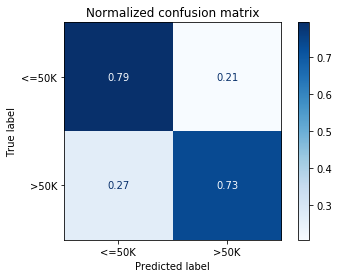

In [123]:
plotCM(best_dt)

* A lot better
* Can optimize further by running GridSearch again on narrower range of hyperparameters

### Classification: Random Forest

In [82]:
from sklearn.ensemble import RandomForestClassifier

#### Unbalanced: 

In [83]:
urf_model = RandomForestClassifier().fit(X_train, y_train)
urf_model.score(X_test, y_test)

0.811342402884773

Normalized confusion matrix
[[0.89326024 0.10673976]
 [0.45153501 0.54846499]]


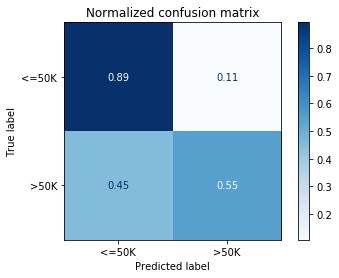

In [84]:
plotCM(urf_model)

* Already better than unbalanced, unoptimized decision tree model

#### Balanaced:

In [150]:
rf_model = RandomForestClassifier(class_weight = "balanced").fit(X_train, y_train)
rf_model.score(X_test, y_test)

0.8074086215374529

In [152]:
cross_val_score(rf_model, X_train, y_train)

array([0.80756624, 0.80672039, 0.80945226, 0.80590083, 0.80371534])

Normalized confusion matrix
[[0.87186929 0.12813071]
 [0.41324595 0.58675405]]


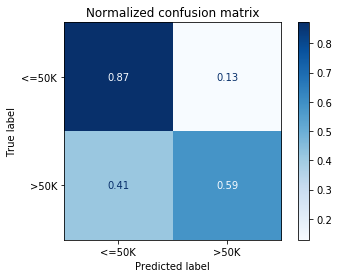

In [88]:
plotCM(rf_model)

* False negative rate is still very high -- what can we do to improve this?